## Visualize Diagnostics

Dropdown(description='Diagnostics File:', layout=Layout(width='max-content'), options=('c:\\Users\\u251245\\CV…

IntSlider(value=5, continuous_update=False, description='SMA Window Size:', layout=Layout(width='max-content')…

diagnostic_save_path\roc_pr_curves_20240621_140118.png


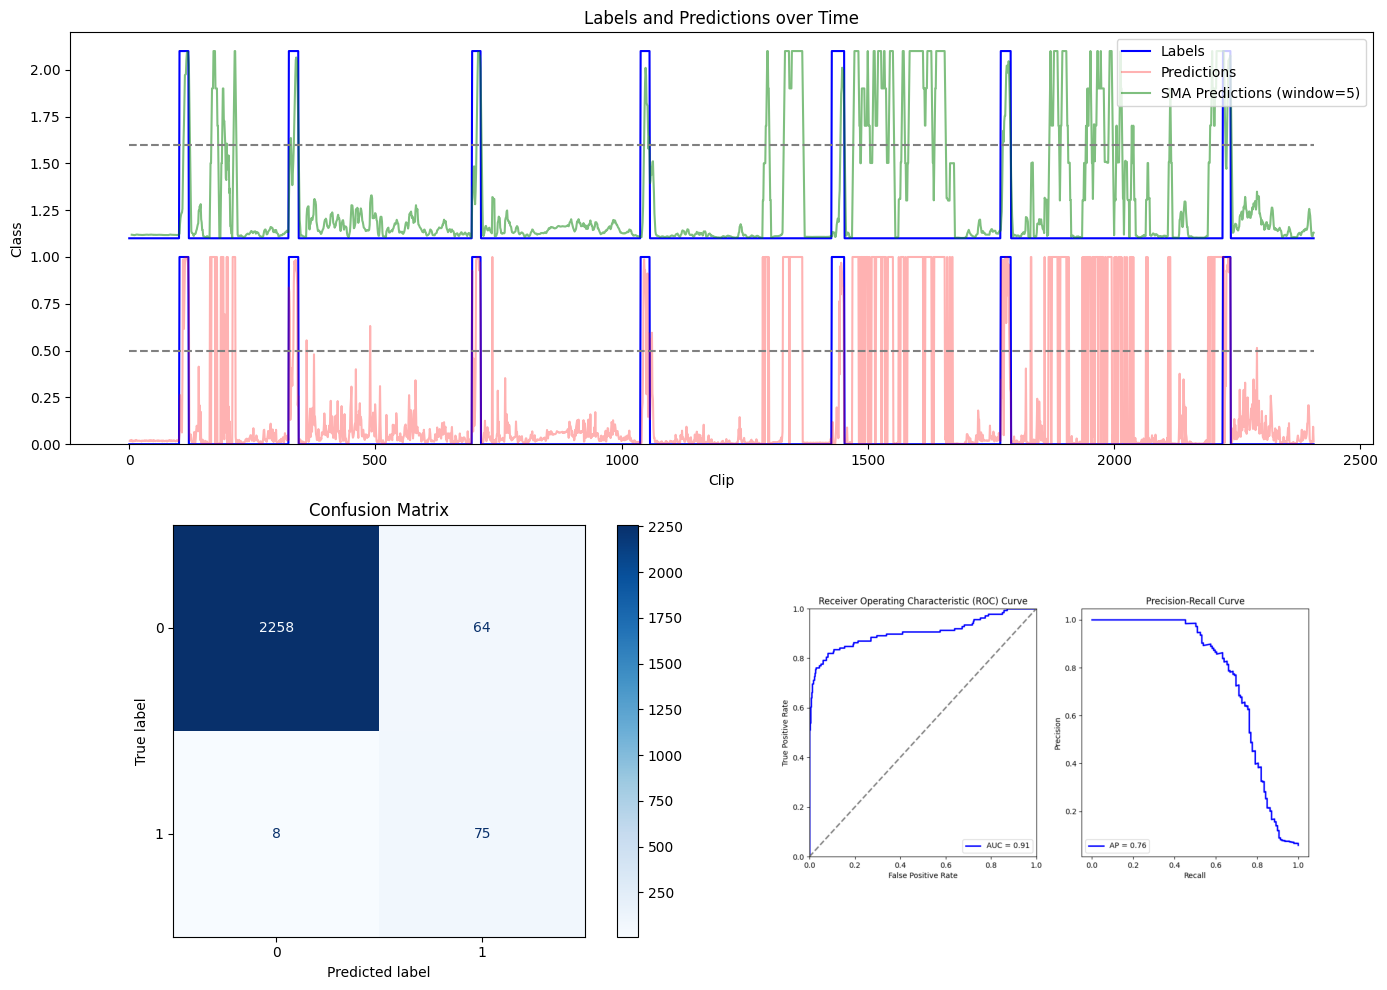

In [26]:
import re
import numpy as np
import matplotlib.pyplot as plt
import ast
from sklearn.metrics import ConfusionMatrixDisplay
import os
import ipywidgets as widgets
from IPython.display import display, clear_output

def parse_predictions(preds_str):
    preds = []
    preds_str = preds_str.strip()[1:-1]  # Remove the outer brackets
    preds_list = preds_str.split('array(')
    for pred in preds_list[1:]:
        pred_values = re.findall(r"[-+]?\d*\.\d+|\d+", pred.split(']')[0])
        preds.append(min(float(pred_values[1]), 1.0))  # Take the second value for the positive class probability
    return preds

def simple_moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

def plot_diagnostics(diagnostics_path, sma_window_size=5):
    # Read and parse the diagnostics text file
    with open(diagnostics_path, 'r') as file:
        content = file.read()
    
    # Extract confusion matrix
    confusion_matrix_pattern = re.compile(r'Confusion Matrix:\n\[\[([0-9\s]+)\]\n \[([0-9\s]+)\]\]')
    confusion_matrix_match = confusion_matrix_pattern.search(content)
    if confusion_matrix_match:
        cm = np.array([
            list(map(int, confusion_matrix_match.group(1).split())),
            list(map(int, confusion_matrix_match.group(2).split()))
        ])
    
    # Extract labels
    labels_pattern = re.compile(r'Labels:\n\[(.*)\]')
    labels_match = labels_pattern.search(content)
    if labels_match:
        labels = ast.literal_eval(labels_match.group(1))
        labels2 = np.array(labels) + 1.1

    # Extract predictions
    preds_pattern = re.compile(r'Preds:\n\[(.*)\]')
    preds_match = preds_pattern.search(content)
    if preds_match:
        preds = parse_predictions(preds_match.group(1))
        preds2 = np.array(preds) + 1.1

    # Extract images saved for ROC and PC curves
    roc_pr_pattern = re.compile(r'Combined ROC and Precision-Recall Curves saved at: (.*)')
    roc_pr_match = roc_pr_pattern.search(content)
    roc_pr_image_path = None
    if roc_pr_match:
        roc_pr_image_path = roc_pr_match.group(1).strip()
        print(roc_pr_image_path)
    
    # Calculate the time intervals based on the length of the video
    time_intervals = np.linspace(0, len(labels), len(labels))

    # Calculate the simple moving average of the predictions
    sma_preds = simple_moving_average(preds, sma_window_size)
    sma_preds2 = np.array(sma_preds) + 1.1

    fig, axs = plt.subplots(2, 2, figsize=(14, 10))
    gs = axs[0, 0].get_gridspec()
    # Remove the underlying axes
    for ax in axs[0, :]:
        ax.remove()
    axbig = fig.add_subplot(gs[0, :])

    # Plot labels and predictions over time
    axbig.plot(time_intervals, labels, label='Labels', color='blue')
    axbig.plot(time_intervals[1:], preds, label='Predictions', color='red', alpha=0.3)
    axbig.plot(time_intervals, labels2, color='blue')
    axbig.plot(time_intervals[sma_window_size:], sma_preds2, label=f'SMA Predictions (window={sma_window_size})', color='green', alpha=0.5)
    axbig.set_xlabel('Clip')
    axbig.set_ylabel('Class')
    axbig.set_ylim(0,2.2)
    axbig.set_title('Labels and Predictions over Time')
    axbig.hlines([0.5,1.6],[0,0],[max(time_intervals),max(time_intervals)], colors=['grey','grey'],linestyles=['dashed','dashed'] )
    axbig.legend()

    # Plot confusion matrix
    ConfusionMatrixDisplay(confusion_matrix=cm).plot(cmap='Blues', values_format='d', ax=axs[1, 0])
    axs[1, 0].set_title('Confusion Matrix')

    # Plot ROC and Precision-Recall Curves image
    if roc_pr_image_path and os.path.exists(roc_pr_image_path):
        roc_pr_image = plt.imread(roc_pr_image_path)
        axs[1, 1].imshow(roc_pr_image)
        axs[1, 1].axis('off')
        
    plt.tight_layout()
    plt.show()

# List of available diagnostics files
best_diagnostics = [
    'c:\\Users\\u251245\\CVEpilepsy\\diagnostics_TRAIN\\diagnostics_20240621_140118.txt',
    'c:\\Users\\u251245\\CVEpilepsy\\diagnostics_TRAIN\\diagnostics_20240621_142726.txt',
    'c:\\Users\\u251245\\CVEpilepsy\\diagnostics_TRAIN\\diagnostics_20240621_145356.txt',
    'c:\\Users\\u251245\\CVEpilepsy\\diagnostics_TRAIN\\diagnostics_20240621_152020.txt',
    'c:\\Users\\u251245\\CVEpilepsy\\diagnostics_TRAIN\\diagnostics_20240621_154658.txt',
    'c:\\Users\\u251245\\CVEpilepsy\\diagnostics_TRAIN\\diagnostics_20240621_161323.txt',
    'c:\\Users\\u251245\\CVEpilepsy\\diagnostics_TRAIN\\diagnostics_20240621_163956.txt',
    'c:\\Users\\u251245\\CVEpilepsy\\diagnostics_TRAIN\\diagnostics_20240621_170649.txt',
    'c:\\Users\\u251245\\CVEpilepsy\\diagnostics_TRAIN\\diagnostics_20240621_173312.txt',
    'c:\\Users\\u251245\\CVEpilepsy\\diagnostics_TRAIN\\diagnostics_20240621_175919.txt',
    'c:\\Users\\u251245\\CVEpilepsy\\diagnostics_TRAIN\\diagnostics_20240621_182529.txt',
    'c:\\Users\\u251245\\CVEpilepsy\\diagnostics_TRAIN\\diagnostics_20240621_185158.txt',
    'c:\\Users\\u251245\\CVEpilepsy\\diagnostics_TRAIN\\diagnostics_20240621_191810.txt',
    'c:\\Users\\u251245\\CVEpilepsy\\diagnostics_TRAIN\\diagnostics_20240621_194356.txt',
    'c:\\Users\\u251245\\CVEpilepsy\\diagnostics_TRAIN\\diagnostics_20240621_200935.txt'
]

# Create widgets for diagnostics file selection and SMA window size
diagnostics_file_widget = widgets.Dropdown(
    options=best_diagnostics,
    description='Diagnostics File:',
    style={'description_width': 'initial'},
    layout={'width': 'max-content'}
)

sma_window_size_widget = widgets.IntSlider(
    value=5, min=1, max=20, step=1,
    description='SMA Window Size:',
    continuous_update=False,
    style={'description_width': 'initial'},
    layout={'width': 'max-content'}
)

def update_plot(change=None):
    clear_output(wait=True)
    display(diagnostics_file_widget, sma_window_size_widget)
    plot_diagnostics(diagnostics_file_widget.value, sma_window_size_widget.value)

# Observe changes in the widgets
diagnostics_file_widget.observe(update_plot, names='value')
sma_window_size_widget.observe(update_plot, names='value')

# Initial display of widgets
display(diagnostics_file_widget, sma_window_size_widget)
update_plot()

In [25]:
base_path = 'C:/Users/u251245/CVEpilepsy/'
diagnostic_path = 'diagnostic_save_path/'
video_path = '/videos/'

best_diagnostics = ['c:\\Users\\u251245\\CVEpilepsy\\diagnostics_TRAIN\\diagnostics_20240621_140118.txt', 'c:\\Users\\u251245\\CVEpilepsy\\diagnostics_TRAIN\\diagnostics_20240621_142726.txt', 'c:\\Users\\u251245\\CVEpilepsy\\diagnostics_TRAIN\\diagnostics_20240621_145356.txt', 'c:\\Users\\u251245\\CVEpilepsy\\diagnostics_TRAIN\\diagnostics_20240621_152020.txt', 'c:\\Users\\u251245\\CVEpilepsy\\diagnostics_TRAIN\\diagnostics_20240621_154658.txt', 'c:\\Users\\u251245\\CVEpilepsy\\diagnostics_TRAIN\\diagnostics_20240621_161323.txt', 'c:\\Users\\u251245\\CVEpilepsy\\diagnostics_TRAIN\\diagnostics_20240621_163956.txt', 'c:\\Users\\u251245\\CVEpilepsy\\diagnostics_TRAIN\\diagnostics_20240621_170649.txt', 'c:\\Users\\u251245\\CVEpilepsy\\diagnostics_TRAIN\\diagnostics_20240621_173312.txt', 'c:\\Users\\u251245\\CVEpilepsy\\diagnostics_TRAIN\\diagnostics_20240621_175919.txt', 'c:\\Users\\u251245\\CVEpilepsy\\diagnostics_TRAIN\\diagnostics_20240621_182529.txt', 'c:\\Users\\u251245\\CVEpilepsy\\diagnostics_TRAIN\\diagnostics_20240621_185158.txt', 'c:\\Users\\u251245\\CVEpilepsy\\diagnostics_TRAIN\\diagnostics_20240621_191810.txt', 'c:\\Users\\u251245\\CVEpilepsy\\diagnostics_TRAIN\\diagnostics_20240621_194356.txt', 'c:\\Users\\u251245\\CVEpilepsy\\diagnostics_TRAIN\\diagnostics_20240621_200935.txt']

dx_file = 'diagnostics_20240620_201208.txt'
patients = ['00582992', '00913367', '02267738', '02268547',
            '05109836', '05235825', '05323733', '05352576',
            '05418761', '05447543', '05454991', '05463487',
            '05467817', '05486196', '05489744', '05497695',
            '05501184', '05512494', '05513119', '05514820',
            '06338772', '06348578', '06381028', '06394294',
            '06452950']

ex_dx = os.path.join(base_path,diagnostic_path,dx_file)

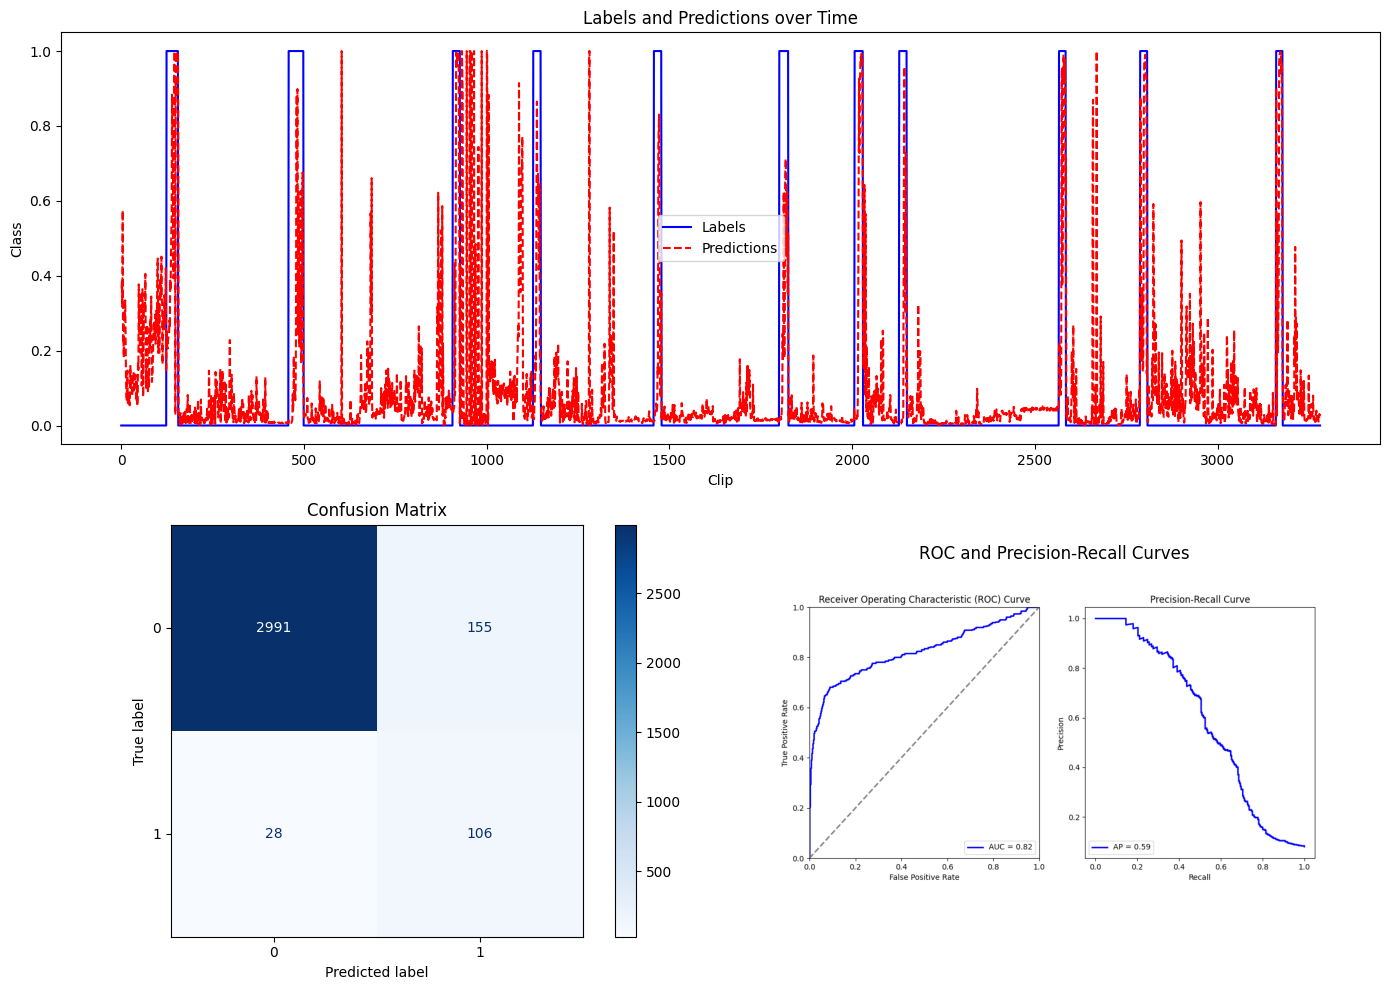

Dropdown(description='Diagnostics File:', index=15, options=('C:/Users/u251245/CVEpilepsy/diagnostic_save_path…

In [27]:
def select_diagnostics_file(change):
    clear_output()  # Clear the current output
    diagnostics_file = change['new']
    video_file = ""
    patient_list = []  # Assuming patient_list is not used in this context
    plot_diagnostics(diagnostics_file, video_file, patient_list)
    display(diagnostics_dropdown)  # Redisplay the dropdown after clearing output

# Assuming base_path and diagnostic_path are defined
diagnostic_save_path = os.path.join(base_path, diagnostic_path)
print(diagnostic_save_path)

# Get list of diagnostics files
diagnostics_files = [os.path.join(diagnostic_save_path, f) for f in os.listdir(diagnostic_save_path) if f.endswith('.txt')]

# Dropdown widget to select diagnostics file
diagnostics_dropdown = widgets.Dropdown(
    options=diagnostics_files,
    description='Diagnostics File:',
    disabled=False,
)

# Link the dropdown selection change to the function
diagnostics_dropdown.observe(select_diagnostics_file, names='value')

# Display the widgets
display(diagnostics_dropdown)

### Generate all GradCam videos

In [4]:
import re

def parse_patient_info(file_path):
    patients = {}
    current_patient = None
    
    with open(file_path, 'r') as file:
        for line in file:
            # Check if the line is a patient header
            header_match = re.match(r'Patient (\d+) \((\d+)\):', line)
            if header_match:
                patient_number = header_match.group(1)
                patient_id = header_match.group(2)
                current_patient = {
                    'ID': patient_id,
                    'Videos': []
                }
                patients[patient_number] = current_patient
            # Check if the line is a video entry
            elif current_patient:
                video_match = re.match(r'\(\'Videos\/(.+?)\.mp4\', \d+, \d+, \'(.+?)\', sec\)', line)
                if video_match:
                    video_id = video_match.group(2)
                    current_patient['Videos'].append(video_id)
    
    return patients

file_path = 'annotations/usuable_data.txt'
patients = parse_patient_info(file_path)

{'1': {'ID': '06348578', 'Videos': ['7942GT00', '7942GU00', '7942GZ00']}, '2': {'ID': '05501184', 'Videos': ['7913ZY00']}, '3': {'ID': '05418761', 'Videos': ['7972M300']}, '4': {'ID': '06394294', 'Videos': ['7942QQ00', '7942QR00', '00200200']}, '5': {'ID': '05467817', 'Videos': ['7971Q500']}, '6': {'ID': '05323733', 'Videos': ['7971UI00']}, '7': {'ID': '05486196', 'Videos': ['7941M700']}, '8': {'ID': '05514820', 'Videos': ['7941LY00']}, '9': {'ID': '05513119', 'Videos': ['00200100']}, '10': {'ID': '02267738', 'Videos': ['7941EC00']}, '11': {'ID': '05447543', 'Videos': ['7941D100', '7941D200', '7941D300', '7941D400', '7941D500', '7941D600']}, '12': {'ID': '02268547', 'Videos': ['7940K700']}, '13': {'ID': '05454991', 'Videos': ['79410R00']}, '14': {'ID': '05497695', 'Videos': ['7941E901', '7941EA00', '7971C500', '7971C700']}, '15': {'ID': '05463487', 'Videos': ['79519000']}, '16': {'ID': '05235825', 'Videos': ['79719R00']}, '17': {'ID': '05352576', 'Videos': ['7970IA00', '7940HO00', '794

In [7]:
import os
import subprocess

def generate_gradcam_commands(input_dict):
    commands = []
    
    for entry in input_dict.values():
        id = entry['ID']
        videos = entry['Videos']
        
        # Find the best_top1_acc file
        checkpoint_dir = f"checkpoints/train_all/{id}/"
        best_checkpoint = next((file for file in os.listdir(checkpoint_dir) if file.startswith("best_top1_acc")), None)
        
        if best_checkpoint:
            for video in videos:
                command = (
                    f"python tools/aidan_gradcam.py i3d_gaussian/i3d_config_{id}.py "
                    f"checkpoints/train_all/{id}/{best_checkpoint} "
                    f"videos/{video}.mp4 --target-layer-name backbone/layer4/1/relu "
                    f"--out-filename Video_GradCam/{video}_GradCam.mp4"
                )
                commands.append(command)
    
    return commands

def run_commands(commands):
    for i, command in enumerate(commands, 1):
        print(f"Running command {i} of {len(commands)}:")
        print(command)
        try:
            subprocess.run(command, shell=True, check=True)
            print(f"Command {i} completed successfully.\n")
        except subprocess.CalledProcessError as e:
            print(f"Command {i} failed with error: {e}\n")

commands = generate_gradcam_commands(patients)
run_commands(commands)

Running command 1 of 49:
python tools/aidan_gradcam.py i3d_gaussian/i3d_config_06348578.py checkpoints/train_all/06348578/best_top1_acc_epoch_1.pth videos/7942GT00.mp4 --target-layer-name backbone/layer4/1/relu --out-filename Video_GradCam/7942GT00_GradCam.mp4
Command 1 completed successfully.

Running command 2 of 49:
python tools/aidan_gradcam.py i3d_gaussian/i3d_config_06348578.py checkpoints/train_all/06348578/best_top1_acc_epoch_1.pth videos/7942GU00.mp4 --target-layer-name backbone/layer4/1/relu --out-filename Video_GradCam/7942GU00_GradCam.mp4
Command 2 completed successfully.

Running command 3 of 49:
python tools/aidan_gradcam.py i3d_gaussian/i3d_config_06348578.py checkpoints/train_all/06348578/best_top1_acc_epoch_1.pth videos/7942GZ00.mp4 --target-layer-name backbone/layer4/1/relu --out-filename Video_GradCam/7942GZ00_GradCam.mp4
Command 3 completed successfully.

Running command 4 of 49:
python tools/aidan_gradcam.py i3d_gaussian/i3d_config_05501184.py checkpoints/train_all